In [3]:
#location of the file path
#/root/hackerday/11_allstate_insurance/train.csv.zip
#/root/hackerday/11_allstate_insurance/test_v2.csv.zip
#/root/hackerday/11_allstate_insurance/sampleSubmission.csv

#location of the file path
#unzip("/root/hackerday/11_allstate_insurance/train.csv.zip",exdir = "/root/hackerday/11_allstate_insurance/")
#train = read.csv("/root/hackerday/11_allstate_insurance/train.csv")

#unzip("/root/hackerday/11_allstate_insurance/test_v2.csv.zip",exdir = "/root/hackerday/11_allstate_insurance/")
#test_v2 = read.csv("/root/hackerday/11_allstate_insurance/test_v2.csv")

#/root/hackerday/11_allstate_insurance/train.csv.zip
#/root/hackerday/11_allstate_insurance/test_v2.csv.zip
#/root/hackerday/11_allstate_insurance/sampleSubmission.csv


In [5]:
import pandas as pd
from pandas import Series, DataFrame

In [8]:
train = pd.read_csv("/root/hackerday/11_allstate_insurance/train.csv")
print train.head()

   customer_ID  shopping_pt  record_type  day   time state  location  \
0     10000000            1            0    0  08:35    IN     10001   
1     10000000            2            0    0  08:38    IN     10001   
2     10000000            3            0    0  08:38    IN     10001   
3     10000000            4            0    0  08:39    IN     10001   
4     10000000            5            0    0  11:55    IN     10001   

   group_size  homeowner  car_age  ...  C_previous  duration_previous  A  B  \
0           2          0        2  ...           1                  2  1  0   
1           2          0        2  ...           1                  2  1  0   
2           2          0        2  ...           1                  2  1  0   
3           2          0        2  ...           1                  2  1  0   
4           2          0        2  ...           1                  2  1  0   

   C  D  E  F  G  cost  
0  2  2  1  2  2   633  
1  2  2  1  2  1   630  
2  2  2  1  2  1 

In [11]:
train[["cost","car_age"]].describe()

,cost,car_age
count,665249.000000,665249.000000
mean,635.785008,8.139437
std,45.993758,5.764598
min,260.000000,0.000000
25%,605.000000,3.000000
50%,635.000000,7.000000
75%,665.000000,12.000000
max,922.000000,85.000000


In [12]:
import matplotlib.pyplot as plt

In [13]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


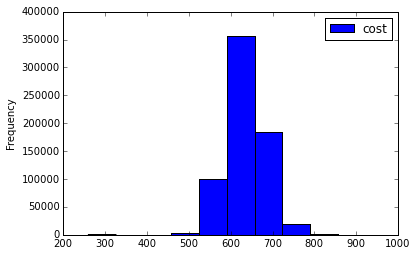

In [15]:
train[["cost"]].plot(kind="hist")

In [17]:
# data preparation and utilities
from time import time
from itertools import combinations
from sklearn import preprocessing
import scipy as sp, numpy as np, pandas as pd

In [18]:
#Cantor Pariing
def cantor(args):
    if len(args) > 2:
        x2 = cantor(args[1:])
        x1 = args[0]
    else:
        x1, x2 = args
    return int((0.5 * (x1 + x2)*(x1+x2+1)+x2))


In [19]:
# groups all columns of data into combinations 
def group_data(data, degree=3, hash=hash, NAMES=None):
    init = time()
    new_data = []; combined_names = []
    m, n = data.shape
    for indicies in combinations(range(n), degree):
        new_data.append([hash(tuple(v)) for v in data[:,indicies]])
        if NAMES != None:
            combined_names.append('+'.join([NAMES[indicies[i]] for i in range(degree)]))
    print "Done! %.2fm" % ((time()-init)/60)
    if NAMES != None:
        return (np.array(new_data).T,combined_names)
    return np.array(new_data).T

In [27]:
#returns concatenated field in a dataframe
def concat(df, columns):
    return np.array([''.join(x) for x in np.array(
                [np.array(df[col].values), dtype=str) for col in columns]).T])
###Review the function###

SyntaxError: invalid syntax (<ipython-input-27-eb67ea3411d4>, line 4)

In [28]:
#addition of state names to the dataset
def stateFix(encoders, df, c=['C','D','G'], verbose = False):
    #GA
    iGA = df.state == encoders['state'].transform(['GA'])[0]
    ifix = iGA&(df[c[0]]==1);df.ix[ifix,c[0]] = 2; nga1 = np.sum(ifix) #C
    ifix = iGA&(df[c[1]]==1);df.ix[ifix,c[1]] = 2; nga2 = np.sum(ifix) #D
    #FL
    iFL = df.state == encoders['state'].transform(['FL'])[0]
    ifix = iFL&(df[c[2]]<=2);df.ix[ifix,c[2]] = 3; nfl1 = np.sum(ifix) #G
    #OH
    iOH = df.state == encoders['state'].transform(['OH'])[0]
    ifix = iOH&(df[c[2]]==1);df.ix[ifix,c[2]] = 2; noh1 = np.sum(ifix) #G
    #ND
    #OH
    iND = df.state == encoders['state'].transform(['ND'])[0]
    ifix = iND&(df[c[2]]!=2);df.ix[ifix,c[2]] = 2; nnd1 = np.sum(ifix) #G
    #SD
    iSD = df.state == encoders['state'].transform(['SD'])[0]
    ifix = iSD&(df[c[2]]!=2);df.ix[ifix,c[2]] = 2; nsd1 = np.sum(ifix) #G
    if verbose:
        print " Fixed state law products" %(nga1, nga2, nfl1, noh1, nnd1, nsd1)
        

In [29]:
#target variable expected value
def expval(df,col,y,tfilter):
    tmp = pd.DataFrame(index=df.index)
    pb = df[tfilter][y].mean() #train set mean computation
    tmp['cnt'] = df[col].map(df[tfilter][col].value_counts()).fillna(0) # set count 
    tmp['csm'] = df[col].map(df[tfilter].groupby(col)[y].sum()).fillna(pb) # set sum
    tmp.ix[tfilter,'cnt'] -= 1 #reduce count for training set
    tmp.ix[tfilter,'csm'] -= df.ix[tfilter,y] # removing the current value
    tmp['exp'] = ((tmp.csm+pb*15)/(tmp.cnt+15)).fillna(pb) #calculating the mean including the average samples
    np.random.seed(1)
    tmp.ix[tfilter,'exp'] *= 1+0.3*(np.random.rand(len(tmp[tfilter]))-.5) #adding random noise to the training dataset
    return tmp.exp

In [30]:
#data preparation function
def prepare_data(shuffle=True):
    alltest = pd.read_csv('/root/hackerday/11_allstate_insurance/test_v2.csv')
    test = alltest.set_index('customer_ID')
    alldata = pd.read_csv('/root/hackerday/11_allstate_insurance/train.csv').set_index('customer_ID')
    
    con = ['group_size','car_age','age_oldest','age_youngest','duration_previous','cost']
    cat = ['homeowner','car_value','risk_factor','married_couple','C_previous','state','location','shopping_pt']
    conf = ['A','B','C','D','E','F','G']; conf_f = [col+'_f' for col in conf]
    extra = []
    
    final_purchase = alldata[alldata.record_type == 1] # final purchase indicator
    data = alldata.join(final_purchase[conf],rsuffix = '_f') # creating training dataset with the target features
    data = data[data.record_type == 0] #removing final purchase 
    
    data['conf'] = concat(data,conf_f) #for purchase plan
    data['conf_init'] = concat(data,conf) #last quoted plan
    
    encoders = dict()
    data = data.append(test)
    
    #missing value imputation technique implementation
    data['C_previous'].fillna(0, inplace=1)
    data['duration_previous'].fillna(0,inplace=1)
    data.location.fillna(-1,inplace=1)
    
    #transforming the data to numerical data
    for col in ['car_value','risk_factor','state']:
        encoders[col] = preprocessing.LabelEncoder()
        data[col] = encoders[col].fit_transform(data[col].fillna(99))
    print 'Location substitution:',
    
    # location substitution
    x = data[data.shopping_pt==2].location.value_counts()
    sub = data.location.map(x).fillna(0) < 5
    data.ix[sub,'location'] = data.state[sub]; print '%.5f' % sub.mean()
    
    #cost per car_age, cost per person, cost per state
    data['caCost'] = 1.*data.cost / (data.car_age+1)
    data['ppCost'] = 1.*data.cost / (data.group_size)
    data['stCost'] = data.state.map(data.groupby('state')['cost'].mean())
    extra.extend(['caCost','ppCost','stCost'])
    
    #average quote cost by G values
    data['costG'] = data['G'].map(data.groupby('G')['cost'].mean())
    extra.append('costG')
    
    #average quote cost by G and State values
    x = data.groupby(['G','state'])['cost'].mean()
    x = x.reset_index().set_index(['G','state']); x.columns = ['costStG']
    data = data.merge(x, left_on=['G','state'],right_index=True,how='left')
    extra.append('costStG')
    
    #two way intersection between state, G and shopping_pt
    print "Grouping few 2way interactions",
    
    grpTrn, c2 = group_data(data[['state','G','shopping_pt']].values,2,hash,['state','G','shopping_pt'])
    for i,col in enumerate(c2):
        encoders[col] = preprocessing.LabelEncoder()
        data[col] = encoders[col].fit_transform(grpTrn[:,i])
    extra.extend(c2)
    
    #expected value (mean) of G by State and Location
    for col in ['state','location']:
        extra.append(col+'_exp')
        data[col+'_exp'] = expval(data,col,'G_f',-data.G_f.isnull())
    
    #previous G
    data['prev_G'] = data.G.shift(1); extra.append('prev_G')
    data.ix[data.shopping_pt ==1,'prev_G'] = data.ix[data.shopping_pt==1,'G']
    
    #train and testing data separation
    test = data[data.conf.isnull()];data = data[-data.conf.isnull()]
    
    #shuffling the dataset
    if shuffle:
        print " Shuffling dataset",
        np.random.seed(9); ids =np.unique(data.index.values)
        rands = pd.Series(np.random.random_sample(len(ids)),index=ids)
        data['rand'] = data.reset_index()['customer_ID'].map(rands.values)
        data.sort(['rand','shopping_pt'],inplace=1);print "shuffled"
    
    #convert to int due to empty values in test set
    for col in conf_f: data[col] = np.array(data[col].values,dtype=np.int8)
    
    return data, test, con, cat, extra, conf, conf_f, encoders

    

In [34]:
from time import time
from sklearn import ensemble

import multiprocessing, operator
import pandas as pd, numpy as np

from copy_reg import pickle
from types import MethodType


In [35]:
def _pickle_method(method):
    func_name = method.im_func._name_
    obj = method.im_self
    cls = method.im_class
    return _unpickle_method, (func_name, obj, cls)


In [36]:
def _unpickle_method(func_name, obj, cls):
    for cls in cls.mro():
        try:
            func = cls._dict_[func_name]
        except KeyError:
            pass
        else:
            break
    return func._get_(obj,cls)

In [37]:
# class is used to fit and predict in parallel by minimizing memory usage
class RandomForestsParallel(object):
    rfs = []
    def _init_(self,N,ntree,maxfea,leafsize,N_proc=None):
        self.N = N
        self.ntree = ntree; self.maxfea = maxfea; self.leafsize = leafsize
        self.N_proc = N_proc if N_proc is not None else max(1, multiprocessing.cpu_count()-1)
        
        pickle(MethodType, _pickle_method,_pickle_method)
        
    def _parallel_fit(self,rf):
        t = time()
        return rf.fit(self.X,self.y,self.w), (time()-t)/60.
    
    def _parallel_predict(self, rf):
        return rf.predict(self.X)
    
    def fit(self,X,y,w=None):
        #fitting N random forest models in parallel
        self.rfs = []; self.X = X; self.y = y
        self.w = np.ones(y.shape,dtype=bool) if w is None else w
        print " fitting the random forest model %i RFs using %i processes.."% (self.N, self.N_proc),
        
        args = [ensemble.RandomForestClassifier(
            n_estimators = self.ntree, max_features = self.maxfea,
            min_samples_leaf=self.leafsize,random_state=irf,
            compute_importances=1) for irf in range(self.N)]
        if self.N_proc > 1:
            pool = multiprocessing.Pool(self.N_proc)
            for i,(rf,irft) in enumerate(pool.imap(self._parallel_fit, args)):
                self.rfs.append(rf); print "rf#%i % .2fm" % (i, irft),
            pool.terminate()
        else:
            for i, rf in enumerate(args):
                rf, irft = self._parallel_fit(rf)
                self.rfs.append(rf); print "rf#%i % .2fm" % (i, irft),
        del self.X, slef.y, self.w
        
        self.impf =self._calculate_impf(X.columns)
        
        return self
    def predict(self,X,single_process=True):
        self.X = X
        if (not single_process) & (self.N_proc > 1):
            pool = multiprocessing.Pool(self.N_proc)
            allpreds = np.array([self._parallel_predict(rf) for rf in self.rfs]).T
            pool.terminate()
        else:
            allpreds = np.array([self._parallel_predict(rf) for rf in self.rfs]).T
        del self.X
        return allpreds
    
    def _calculate_impf(self, feature_names):
        return pd.Series(reduce(operator.add,[rf.feature_importances_ for rf in self.rfs])/self.N, feature_names)
    
    def _repr_(self):
        return "N: %i N_proc: %i ntree: %i maxfea: %i leafsize: %i fitted: %s" %(
        self.N,self.N_proc, self.ntree, self.maxfea,
        self.leafsize, 'yes' if len(self.rfs) > 0 else 'No')

In [42]:
# in this step we are going to use the utility functions as discussed above to generate the final prediction
import pandas as pd, numpy as np
import matplotlib.pyplot as plt
import operator

from sklearn import cross_validation, ensemble
from time import time


In [43]:
def majority_vote(baseline, model_predictions):
    prcnt = np.vstack([np.bincount(p,minlength=5) for p in model_predictions])
    prmax = np.max(prcnt,axis=1) >= (1+(len(selected)/2))
    preds = baseline+0; preds[prmax] = np.argmax(prcnt[prmax],axis=1)
    return preds


In [44]:
def make_ptscores(y_true,y_pred,y_base,pt,vmask):
    return [np.mean(vmask[pt==ipt]&(y_true[pt==ipt] == y_pred[pt==ipt]))] -np.mean(vmask[pt==ipt]&(y_true[pt==ipt] ==y_base[pt==ipt])
                                                                                  for ipt in range(1,11))


In [ ]:
if _name_=='_main_':
    submit = True; N = 10; NS = 4; kfold = 5; N_proc = None;
    include_from_pt = 1; verbose_selection = False
    tn = np.array([18943,13298,9251,6528,4203,2175,959,281,78])
    
    params = [(20,5,20)]
    
    print " Majority voting %i models, selecting %i\n" % (N,NS)
    
    #initialize the dataset
    data, test, con, cat, extra, conf, conf_f, encoders = prepare_data()
    
    data = data[data.shopping_pt >= include_from_pt]; print " including from shopping point" % data.shopping_pt.min(),
    X = data[con+cat+conf+extra]; y = data['G_f']; w = np.ones(y.shape)
    
    vmask = reduce(operator.and_,data[conf[:-1]].values.T==data[conf_f[:-1]].values.T)
    scores, imp, ptscores = {}, {}, {}
    
    for n, m,l in params:
        t = time();
        scores[(m,l)],imp[(m,l)],ptscores[(m,l)] = [], [],[]
        col_trscores, col_cvscores = [], []
        
        rfs = RandomForestsParallel(N,n,m,l,N_proc)
        
        #cross validation
        for ifold, (itr,icv) in enumerate(cross_validation.KFold(len(y),kfold, indices=False)):
            rfs.fit(X[itr],y[itr],w[itr])
            print "predicting",
            allpreds = rfs.predict(X)
            rftscores = []
            print "selecting models"
            for irf in range(len(rfs.rfs)):
                pG = allpreds[:,irf];ipt2 = data.shopping_pt > 1
                ptscore = make_ptscores(y[icv],pG[icv],data.G[icv],data.shopping_pt[icv],vmask[icv])
                tptscore = make_ptscores(y[itr],pG[itr],data.G[itr],data.shopping_pt[itr],vmask[itr])
                rftscores.append((tn.dot(tptscores[1:]),irf))
                
            rftscores.sort(reverse=1); selected = [x[1] for x in rftscores[:NS]] 
                